# Beam Search Module

> This module handles all aspects of the VAE, including encoding, decoding, and latent space representation.

In [ ]:
#| default_exp search.deterministic

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *
from torchvision.utils import save_image
import torch
import os
from torch import nn
import torch.nn.functional as F
import pandas as pd

In [ ]:
from MAWM.data.loaders import RolloutObservationDataset

# | hide
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

# tf = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((40, 40)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])

dataset = RolloutObservationDataset(
    agent='agent_0',
    root='../marl_grid_data/',
    transform=tf,
    buffer_size=10,
    train=True
)
dataset.load_next_buffer()

Loading file buffer ...:   0%|          | 0/10 

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
img = dataset[100][0]
img.shape

torch.Size([3, 32, 32])

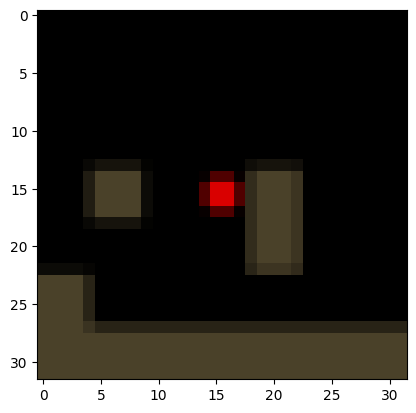

In [ ]:
import matplotlib.pyplot as plt
def unnormalize(img):
    # img: tensor C×H×W
    img = img.clone()
    img = img * 0.5 + 0.5  # reverse Normalize((0.5),(0.5))
    return img
img = unnormalize(img)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
import cv2
import numpy as np
def get_graphics_primitives(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    pixels = img.reshape(-1, 3)
    colors = np.unique(pixels, axis=0)

    primitives = []
    background_color = np.array([0, 0, 0])  # assuming black background
    for color in colors:
        if np.all(color == background_color):
            continue

        mask = cv2.inRange(img, color, color)
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            primitives.append((color, x, y, w, h))
            
    return primitives
    


In [ ]:
primitives = get_graphics_primitives(img.permute(1, 2, 0).numpy())

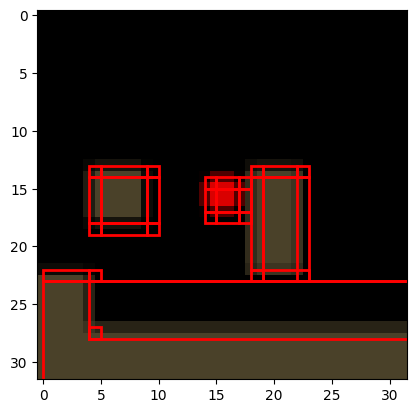

In [ ]:
#draw bounding boxes to the location of the primitives
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
# ax.imshow(cv2.cvtColor(img.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
ax.imshow(img.permute(1, 2, 0).numpy())

for primitive in primitives:
    color, x1, y1, w, h = primitive
    x2, y2 = x1 + w, y1 + h
    
    # Draw rectangle
    ax.add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none', linewidth=2))
    rgb_color = (color[2]/255, color[1]/255, color[0]/255)
    # ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)
    

In [ ]:
def show_grid(img, GRID = 7, CELL = 6):
    import cv2
    import matplotlib.pyplot as plt
    if not CELL:
        CELL = img.shape[0] // GRID
    
    vis = img.copy()
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    for i in range(1, GRID):
        cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
        cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
    plt.imshow(vis, interpolation="nearest")
    plt.axis("off")

    return vis


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
        [0.0000000e+00

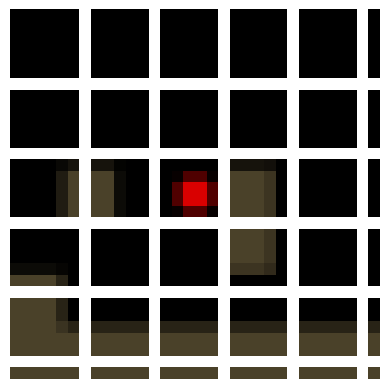

In [ ]:
show_grid(cv2.cvtColor(img.permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

In [ ]:
def get_cell_color(cell):
    np_to_tuple = lambda arr: tuple(int(x) for x in arr)
    pixels = cell.reshape(-1, 3)
    colors, counts = np.unique(pixels, axis=0, return_counts=True)
    # print(colors, len(colors), "+++++")
    # color = colors[np.argmax(counts)]
    if len(colors) == 1:
        if np_to_tuple(colors[0]) in [(0, 255, 0)]:
            return "G" #"Goal"
        elif np_to_tuple(colors[0]) in [(74, 65, 42)]:
            return "W" #"Wall"
        else:
            return "E" #"Empty"
        
    else:
        
        for color in colors:
            if np_to_tuple(color) in [(198, 0, 0), (28, 0, 0), (255, 0, 0)]:
                color = (255, 0, 0)
                return "R" #"RedAgent"
            elif np_to_tuple(color) in [(0, 0, 198), (0, 0, 255)]:
                color = (0, 0, 255)
                return "B" #"BlueAgent"
                
def get_grid_chars(img, GRID=7, CELL=6): 
    cells = [[cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
              for i in range(GRID)]
              for j in range(GRID)
            ]
    
    grid = np.zeros((GRID,GRID), dtype=object)
    for r in range(GRID):
        for c in range(GRID):
            color = get_cell_color(cells[r][c])
            grid[r][c] = color
    return grid

In [ ]:
GRID = 7
W = H = 32

x_edges = np.round(np.linspace(0, W, GRID + 1)).astype(int)
y_edges = np.round(np.linspace(0, H, GRID + 1)).astype(int)


cells = [
    [img[y_edges[j]:y_edges[j+1], x_edges[i]:x_edges[i+1]]
     for i in range(GRID)]
    for j in range(GRID)
]


In [ ]:
def pixel_to_cell(x, y):
    gx = np.searchsorted(x_edges, x, side="right") - 1
    gy = np.searchsorted(y_edges, y, side="right") - 1
    return gx, gy


In [ ]:
cells[0].__len__()

7

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()